# 사람이 말하는 단어를 인공지능 모델로 구분해보자

2차원 Spectrogram 데이터를 입력받아 모델을 아래 제시된 단계와 같이 수행해 보겠습니다.  
기본 버전과 Skip-connection 버전으로 나누어 각각 진행해 보겠습니다.

이제 오늘 만들어볼 음성인식 모델을 위한 학습데이터를 분석해 보겠습니다.  
아래와 같이 환경을 구성한 후, 데이터 다운로드를 진행해 주세요.  
**(주의 : 1.6GB의 대용량 데이터입니다. 다운로드에 시간이 오래걸릴 수 있으니 주의해 주세요.)**

- mkdir -p ~/aiffel/speech_recognition/data  
- mkdir -p ~/aiffel/speech_recognition/models  
- wget https://aiffelstaticdev.blob.core.windows.net/dataset/speech_wav_8000.npz -P ~/aiffel/speech_recognition/data

### 이렇게 다운로드받은 waveform 형태의 데이터에 대해 좀더 자세한 정보를 정리해 봅시다.

**Wave 데이터 형식 뜯어보기**  
Audio 데이터는 이미지 데이터보다 낮은 차원의 데이터를 다룹니다. 1개의 wav 파일은 1차원으로 이루어진 시계열 데이터입니다. 실제로는 여러 소리 파형이 합쳐진 복합파라고 보아야 합니다.

**간단한 단어 인식을 위한 훈련데이터셋**  
짧은 단어의 라벨이 달려 있어, 음성들을 텍스트로 구분하는 모델 혹은 간단한 명령어를 구별하는 모델로도 학습이 가능합니다.

**Bits per sample**  
샘플 하나마다 소리의 세기를 몇 비트로 저장했는지를 나타냅니다.
값이 커질 수록 세기를 정확하게 저장할 수 있습니다.
예를 들어, Bits rate가 16 bits 라면, 소리의 세기를 
2  16, 즉 65,536 단계로 표현할 수 있습니다.
4 bits / 8 bits unsigned int / 16 bits int / 24 bits / 32 bits float 등의 자료형으로 표현됩니다.

**Sampling frequency**  
샘플링 주파수라는 단어입니다. 소리로부터 초당 샘플링한 횟수를 의미합니다.
샘플링은 원래 신호를 다시 복원할 수 있는 나이퀴스트(Nyquist) 샘플링 룰에 따라서, 복원해야 할 신호 주파수의 2배 이상으로 샘플링 해야합니다.
가청 주파수 20 ~ 24 kHz를 복원하기 위해 사용하며, 음원에서 많이 쓰이는 값은 44.1 kHz입니다.

**Channel**  
각 채널별로 샘플링된 데이터가 따로 저장되어 있습니다.
2채널(Stereo) 음원을 재생하면 왼쪽(L)과 오른쪽(R) 스피커에 다른 값이 출력됩니다.
1채널(Mono) 음원의 경우 왼쪽(L) 데이터만 있으며, 재생시엔 왼쪽(L)과 오른쪽(R) 스피커에 같은 값이 출력됩니다.

In [1]:
import numpy as np
import os
import IPython.display as ipd
import random
import tensorflow as tf
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import matplotlib.pyplot as plt

사용할 모듈들 입니다.

In [2]:
# import numpy as np
# import os

data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


**데이터셋 살펴보기 : npz 파일로 이뤄진 데이터이며, 각각 데이터는 "wav_vals", "label_vals"로 저장되어있습니다.**

In [3]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


- 데이터셋은 1초 길이의 오디오 음성데이터 **50620개**로 이뤄져 있습니다.  
- 데이터셋은 캐글의 음성 인식 챌린지의 데이터입니다.  
- 주어진 데이터의 원래 Sample rate는 16000이지만, 8000으로 re-sampling해 사용하겠습니다.  
- 모두 1초의 길이를 가지는 오디오 음성데이터이여서 각각 **8000개**의 sample data를 가지고 있습니다.

위에서 설명한 데이터가 맞는지 확인해봅시다.

In [4]:
# import IPython.display as ipd
# import random

# 데이터 선택 (랜덤하게 선택하고 있으니, 여러번 실행해 보세요)
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)  # 음성을 들을 수 있게 해주는 코드

rand num :  42065
Wave data shape :  (8000,)
label :  ['yes']


## 1. 데이터 처리와 분류

**Label data 처리 : 학습을 위해서는 Text 데이터를 학습가능한 형태로 만들어줘야 합니다.**

아래는 구분해야할 label 목록입니다.

['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go' ]

이외 데이터들은 'unknown', 'silence'로 분류되어 있습니다.

In [5]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


Text로 이루어진 라벨 데이터를 학습에 사용하기 위해서 index 형태로 바꿔주는 작업을 하였습니다.

int로 이뤄진 index 작업을 통해서 Label data를 더 쉽게 사용할 수 있습니다.

In [6]:
temp = []
for v in speech_data["label_vals"]:  # label_val : 타겟값
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

**학습을 위한 데이터 분리 : sklearn의 train_test_split 함수를 이용해 train data와 test data를 분리**

In [7]:
# from sklearn.model_selection import train_test_split

sr = 8000
train_wav, test_wav, train_label, test_label = train_test_split(speech_data["wav_vals"], 
                                                                label_data, 
                                                                test_size=0.2,  # test_size의 인자를 조절해주면, 설정해 준 값만큼 Test dataset의 비율을 조정할 수 있음!
                                                                shuffle=True)
print(train_wav)

train_wav = train_wav.reshape([-1, sr, 1]) # add channel for CNN
test_wav = test_wav.reshape([-1, sr, 1])
print("✅")

[[ 7.81660947e-06 -5.97482085e-06 -3.24129360e-05 ... -5.14028841e-07
   1.17602576e-04  1.56978582e-04]
 [-3.14194732e-03 -6.20333850e-03 -6.80950703e-03 ...  2.74934131e-03
   2.19548657e-03  5.30202268e-03]
 [ 3.26142134e-03  4.76182159e-03  1.15054965e-04 ...  2.62106187e-03
   2.08210852e-03 -1.80397951e-03]
 ...
 [ 3.08633782e-03  4.34793904e-03 -4.18288080e-04 ...  2.74584163e-03
   1.92458800e-03 -1.29721151e-03]
 [-6.01143241e-02  2.38282382e-02 -4.38359380e-02 ... -1.85854640e-02
  -4.28747497e-02 -6.56643137e-03]
 [-1.70227066e-02 -3.09291817e-02 -2.95980070e-02 ...  4.68188040e-02
   3.86227183e-02  3.37119997e-02]]
✅


나눠진 데이터셋을 확인해 볼까요?

In [8]:
print("train data : ", train_wav.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_wav.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (40496, 8000, 1)
train labels :  (40496,)
test data :  (10124, 8000, 1)
test labels :  (10124,)
✅


## 2. 학습을 위한 하이퍼파라미터 설정

모델 체크포인트 저장을 위한 체크포인트의 경로를 설정해줍니다.  
후에 모델 체크포인트 Callback 함수를 설정하거나, 모델을 불러올때 사용합니다.

In [9]:
batch_size = 32
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/aiffel-dj49/aiffel/speech_recognition/models/wav'

## 3. 데이터셋 구성

map 함수는 dataset이 데이터를 불러올때마다 동작시킬 데이터 전처리 함수를 매핑해 주는 역할을 합니다. 첫번째 map 함수는 from_tensor_slice 에 입력한 튜플 형태로 데이터를 받으며 return 값으로 어떤 데이터를 반환할지 결정합니다.
map 함수는 중첩해서 사용이 가능합니다.

아래와 같이, map 함수에 넘겨줄 데이터 전처리 함수를 작성해 봅시다.

In [10]:
def one_hot_label(wav, label):
    label = tf.one_hot(label, depth=12)
    return wav, label
print("✅")

✅


tf.data.Dataset 함수를 이용해서 데이터셋을 구성하겠습니다.  
Tensorflow에 포함된 이 데이터셋 관리 패키지는 데이터셋 전처리, 배치처리 등을 쉽게 할 수 있도록 해 줍니다. 자주 사용하게 되니 사용법을 잘 익혀 둡시다.

In [11]:
# import tensorflow as tf

# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_wav, train_label))  # return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있습니다.
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_wav, test_label))  # return 받길 원하는 데이터를 튜플 (data, label) 형태로 넣어서 사용할 수 있습니다.
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)  # dataset에서 제공하는 튜플 형태의 데이터를 얼마나 가져올지 결정하는 함수
print(test_dataset)
print("✅")

<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 8000, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


- 주의 : waveform을 spectrogram으로 변환하기 위해 추가로 사용하는 메모리 때문에 이후 메모리 부족 현상을 겪게 될수도 있습니다.
- tf.data.Dataset이 생성된 이후, 아래 예시와 같이 wav 데이터나 spectrogram 데이터를 담아둔 메모리 버퍼를 비워 주면 도움이 됩니다.

In [12]:
# del speech_data  
# del spec_data

## 4. 2차원 Spectrogram 데이터를 처리하는 모델 구성

- 2차원 Spectrogram 데이터의 시간축 방향으로 Conv1D layer를 적용, 혹은 Conv2D layer를 적용 가능
- batchnorm, dropout, dense layer 등을 이용
- 12개의 단어 class를 구분하는 loss를 사용하고 Adam optimizer를 사용
- 모델 가중치를 저장하는 checkpoint callback 함수 추가
- 다양한 모델의 실험을 진행해 보시기 바랍니다.

**Spectrogram이란?**

wav 데이터를 해석하는 방법 중 하나로, 일정 시간동안 wav 데이터 안의 다양한 주파수들이 얼마나 포함되어 있는 지를 보여줍니다.
이 Spectrogram을 그리는 방법이 바로 위에 소개한 STFT 입니다.

X축은 시간, Y축은 주파수를 나타내며, 해당 시간/주파수에서의 음파 강도에 따라 밝은색으로 표현됩니다.
wav 데이터가 단위 시간만큼 Short Time Fourier Transform을 진행해 매 순간의 주파수 데이터들을 얻어서 Spectrogram을 완성합니다.

Step2에서 사용한 샘플데이터를 이용하여 스펙트로그램을 생성해 봅시다.

먼저 파이썬에서 제공하는 FFT 관련 라이브러리인 librosa를 설치합니다.

pip install librosa

In [13]:
# import librosa

def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [14]:
# 위에서 뽑았던 sample data
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


어떻습니까? 1차원의 Waveform 데이터가 2차원의 Spectrogram 데이터로 변환되었습니다.

그렇다면 방금 변환된 Spectrogram을 출력해보겠습니다.

만약에, 우리가 Waveform 데이터 대신 이 Spectrogram 포맷으로 모든 음성 데이터를 변환한 후 음성인식 모델을 학습시킨다면, 과연 Waveform과 비교했을 때 더 나은 성능을 기대할 수 있을까요?

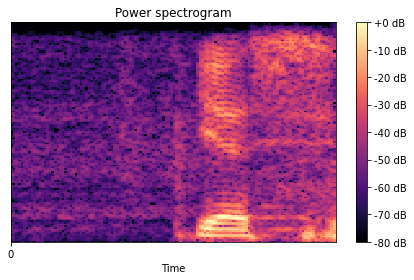

In [15]:
# import librosa.display
# import matplotlib.pyplot as plt

librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

## 5. 학습 후, 학습이 어떻게 진행됐는지 그래프로 출력

###### loss, accuracy를 그래프로 표현

In [16]:
'''train_wav = train_wav.reshape(-1, sr, 126, 1)
#위의 batch된 데이터들과 맞춰준다
#-1옵션은 size를 기반으로 row의 개수를 선정한다
test_wav = test_wav.reshape(-1, sr, 126, 1)'''

from tensorflow.keras import layers
input_tensor = layers.Input(shape=(sr, 126, 1))


x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)

x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav = tf.keras.Model(input_tensor, output_tensor)

model_wav.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(1e-4),
                  metrics=['accuracy'])

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,#checkpoint의 가중치
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

In [17]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

NameError: name 'model_wav_skip' is not defined

In [ ]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

In [ ]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_wav) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_wav) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

In [ ]:
# import matplotlib.pyplot as plt

acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

## 6. Test dataset을 이용해서 모델의 성능을 평가

In [ ]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

In [ ]:
# Test 

inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_wav), size=1, replace=False)

batch_xs = test_wav[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model_wav_skip(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(8000,), rate=8000)

- 저장한 weight 불러오기
- 모델의 예측값과 정답값이 얼마나 일치하는지 확인

In [ ]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

## 루브릭 평가

1. 음성데이터를 2차원 Spectrogram 으로 변환하여 데이터셋을 구성하였다.

스펙트로그램 시각화 및 train/test 데이터셋 구성이 정상진행되었다.

2. 1,2차원 데이터를 처리하는 음성인식 모델이 정상 작동한다.

스펙트로그램을 입력받은 모델이 학습과정에서 안정적으로 수렴하며, evaluation/test 단계를 무리없이 진행가능하다.

3. 테스트셋 수행결과 음성인식 모델의 Accuracy가 일정 수준에 도달하였다.

evaluation 결과 75% 이상의 정확도를 달성하는 모델이 하나 이상 존재한다.